In [31]:
import os

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
from sklearn.metrics import auc, precision_recall_curve, roc_curve
import torch
import torch.nn as nn
import torch_geometric as pyg
import torch_geometric.nn as gnn

In [2]:
sns.set_style('darkgrid')
np.random.seed(42)

# Setup

## Dataset

In [212]:
def get_data(cell_type, subset=(750, 750, 750), gene_list=None, seed=42):
    np.random.seed(seed)
    
    # Get graph
    data_folder = './data/training_matrices_DGL/'
    mat = pd.read_csv(data_folder + f'{cell_type}.feat.mat', index_col=0, sep='\t')
    genes = np.array(mat.columns)
    assert (genes == np.array(mat.index)).all()

    # Get labels
    meta = pd.read_csv(data_folder + 'training_labels.txt', index_col=0, sep='\t')
    labels = meta.values[:, 0]
    labels = np.array([str(meta.loc[g]['label']) if g in meta.index else 'unknown' for g in genes])

    ### SUBSET
    if gene_list is not None:
        subset_idx = np.argwhere([g in gene_list for g in genes]).flatten()
    elif subset is not None:
        # subset_idx = np.random.choice(len(labels), 1000, replace=False)
        ad_labels = np.argwhere(labels == 'AD').flatten()
        notad_labels = np.argwhere(labels == 'notAD').flatten()
        unknown_labels = np.argwhere(labels == 'unknown').flatten()
        subset_idx = np.concatenate([
            np.random.choice(ad_labels, min(len(ad_labels), subset[0]), replace=False),
            np.random.choice(notad_labels, min(len(notad_labels), subset[1]), replace=False),
            np.random.choice(unknown_labels, min(len(unknown_labels), subset[2]), replace=False)])
    if gene_list is not None or subset is not None:
        mat = mat.iloc[subset_idx, subset_idx]
        genes = genes[subset_idx]
        labels = labels[subset_idx]
    ###

    # Sort labels
    ad_labels = np.argwhere(labels == 'AD').flatten()
    notad_labels = np.argwhere(labels == 'notAD').flatten()
    unknown_labels = np.argwhere(labels == 'unknown').flatten()
    known_labels = np.array(list(set(range(len(genes))) - set(unknown_labels)))
    
    # CLI out
    print(f'AD: {len(ad_labels)}; notAD: {len(notad_labels)}; unknown: {len(unknown_labels)}')

    # Split into training and testing
    train_num = int(len(genes) * .8)
    val_num = len(genes) - train_num
    train_idx = np.random.choice(len(genes), train_num, replace=False)
    val_idx = np.array(list(set(range(len(genes))) - set(train_idx)))

    # Masks
    train_mask = [i in train_idx for i in range(len(genes))]
    val_mask = [i in val_idx for i in range(len(genes))]

    # Format sparse
    mat.values[np.eye(mat.values.shape[0] ,dtype=bool)] = 0  # Remove diagonal
    mat = scipy.sparse.coo_matrix(mat.values)
    edge_indices = np.stack([mat.row, mat.col])
    edge_indices = np.concatenate([edge_indices, edge_indices[::-1]], axis=1)  # Make undirected
    edge_weights = np.concatenate([mat.data, mat.data])

    # Construct dataset
    data = pyg.data.Data(
        num_nodes=len(labels),
        node_name=genes,
        y=labels,
        edge_index=torch.tensor(edge_indices).to(torch.int64),
        edge_weight=torch.tensor(edge_weights).to(torch.float64),
        train_mask=train_mask,
        val_mask=val_mask)
    
    return (data, genes), (train_idx, val_idx), (labels, ad_labels, notad_labels, unknown_labels, known_labels)

# Example dataset
# from torch_geometric.datasets import Planetoid
# dataset = Planetoid('./data', 'Cora')[0]
# dataset
# row, col = data.edge_index
# print(col.dtype)
# row, col = dataset.edge_index
# print(col.dtype)

## Embedding Model

In [4]:
# Train model
def train(model, loader, optimizer):
    epoch_loss = 0
    for pos, neg in loader:
        loss = model.loss(pos, neg)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.detach()
        
    return epoch_loss / len(loader)

## AD Prediction

In [5]:
# Create model
class FCL(nn.Module):
    def __init__(self, input_dim, output_dim=1):
        super().__init__()
        
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        self.fcl = nn.Linear(self.input_dim, self.output_dim)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, X):
        return self.sigmoid(self.fcl(X))

# Train model
def train_ad(ad_model, ad_optimizer, ad_criterion, z):
    batch_size = 128
    batches = data.edge_index.shape[1] // batch_size
    epoch_loss = 0
    for j in range(batches):
        seg_size = int(batch_size / 2)
        ad_batch_idx = np.random.choice(np.intersect1d(ad_labels, train_idx), seg_size, replace=True)
        notad_batch_idx = np.random.choice(np.intersect1d(notad_labels, train_idx), seg_size, replace=True)
        batch_idx = np.concatenate([ad_batch_idx, notad_batch_idx])

        true = torch.cat([torch.ones((seg_size, 1)), torch.zeros((seg_size, 1))])
        logits = ad_model(z[batch_idx])
        loss = ad_criterion(logits, true)
        loss.backward()
        ad_optimizer.step()
        epoch_loss += loss.detach()
    epoch_loss /= batches
    
    return epoch_loss

## Training

In [6]:
def generate_models():
    # Construct model
    embedding_dim = 16
    model = gnn.Node2Vec(
        data.edge_index,
        embedding_dim=embedding_dim,
        walk_length=20,
        context_size=10,
        walks_per_node=10,
        num_negative_samples=1,
        p=1,
        q=1,
        num_nodes=len(data.y),
        sparse=True)
    loader = model.loader(batch_size=128, shuffle=True, num_workers=4)
    optimizer = torch.optim.SparseAdam(model.parameters(), lr=1e-2)

    # Train embeddings
    print('Generating embeddings...')
    model.train()
    for i in range(21):
        epoch_loss = train(model, loader, optimizer)
        if i % 2 == 0:
            print(f'Epoch {i} Loss: {epoch_loss:.3f}')
    model.eval()

    # Construct AD Model (NN)
    ad_model = FCL(embedding_dim)
    ad_optimizer = torch.optim.Adam(ad_model.parameters(), lr=1e-2)
    ad_criterion = nn.MSELoss()

    # Train AD Model (NN)
    print('Training AD classification model...')
    z = model()
    ad_model.train()
    for i in range(61):
        epoch_loss = train_ad(ad_model, ad_optimizer, ad_criterion, z)
        if i % 10 == 0:
            print(f'Epoch {i} Loss: {epoch_loss:.3f}')
    ad_model.eval()
    
    # # Construct AD Model (Logistic Regression)
    # z = model().detach().numpy()
    # ad_model = LogisticRegression(solver='lbfgs', multi_class='auto').fit(
    #     z[np.intersect1d(np.union1d(ad_labels, notad_labels), train_idx)],
    #     np.concatenate([np.ones(len(np.intersect1d(ad_labels, train_idx))), np.zeros(len(np.intersect1d(notad_labels, train_idx)))]))
    
    return model, ad_model

## Results

In [7]:
def preview_ad():
    # Predictions
    pred_val = ad_model(model())
    pred = np.array(['AD' if ad else 'notAD' for ad in (pred_val > .5)])

    # Printout
    print('GENE\tPRED\tVALUE\tTRUE')
    for i in np.random.choice(np.intersect1d(ad_labels, val_idx), 10, replace=True):
        print(f'{genes[i]}\t{pred[i]}\t{float(pred_val[i].detach()):.3f}\tAD')
    print()
    print('GENE\tPRED\tVALUE\tTRUE')
    for i in np.random.choice(np.intersect1d(notad_labels, val_idx), 10, replace=True):
        print(f'{genes[i]}\t{pred[i]}\t{float(pred_val[i].detach()):.3f}\tnotAD')
    print()
    print('GENE\tPRED\tVALUE\tTRUE')
    for i in np.random.choice(unknown_labels, 10, replace=True):
        print(f'{genes[i]}\t{pred[i]}\t{float(pred_val[i].detach()):.3f}\tunknown')

def write_predictions(prefix='./'):
    # Predictions
    pred_val = ad_model(model())
    pred = np.array(['AD' if ad else 'notAD' for ad in (pred_val > .5)])
    
    # Write enrichment genes to files
    ad_enrichment = genes[np.intersect1d(np.argwhere(pred == 'AD'), val_idx)]
    notad_enrichment = genes[np.intersect1d(np.argwhere(pred == 'notAD'), val_idx)]
    np.savetxt(prefix + 'AD.txt', ad_enrichment, fmt='%s')
    np.savetxt(prefix + 'notAD.txt', notad_enrichment, fmt='%s')

In [17]:
def get_auroc():
    # Predictions
    pred_val = ad_model(model())
    
    # ROC
    eval_idx = np.intersect1d(val_idx, known_labels)
    fpr, tpr, thresholds = roc_curve(1.*(labels[eval_idx] == 'AD'), pred_val[eval_idx].detach())
    
    return auc(fpr, tpr)

def get_auprc():
    # Predictions
    pred_val = ad_model(model())
    
    # PRC
    eval_idx = np.intersect1d(val_idx, known_labels)
    prec, rec, thresholds = precision_recall_curve(1.*(labels[eval_idx] == 'AD'), pred_val[eval_idx].detach())
    
    return auc(rec, prec)

def plot_roc():
    # Predictions
    pred_val = ad_model(model())
    
    # ROC Curve
    eval_idx = np.intersect1d(val_idx, known_labels)
    fpr, tpr, thresholds = roc_curve(1.*(labels[eval_idx] == 'AD'), pred_val[eval_idx].detach())
    plt.plot(fpr, tpr)
    plt.title(f'ROC Curve ({auc(fpr, tpr)})')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

# Runtime

In [19]:
cell_types = np.array([f[:-9] for f in os.listdir('./data/training_matrices_DGL') if '.mat' in f])
auroc_list, auprc_list = [], []
for i, cell_type in enumerate(cell_types):
    # Set up dir
    if not os.path.exists('results/'):
        os.mkdir('results/')
    if i == 0:
        open('results/auroc.txt', 'w').close()
    if not os.path.exists(f'results/{cell_type}'):
        os.mkdir(f'results/{cell_type}')
    results_dir = f'results/{cell_type}/'
    
    # Get data
    print(f'Loading {cell_type} data...')
    dataset = get_data(cell_type)
    data, genes = dataset[0]
    train_idx, val_idx = dataset[1]
    labels, ad_labels, notad_labels, unknown_labels, known_labels = dataset[2]
    np.savetxt(results_dir + 'genes.txt', genes, fmt='%s')
    
    # Train models
    if os.path.exists(results_dir + 'model.h5') and os.path.exists(results_dir + 'ad_model.h5'):
        print('Loading pre-trained models...')
        model = torch.load(results_dir + 'model.h5')
        ad_model = torch.load(results_dir + 'ad_model.h5')
    else:
        model, ad_model = generate_models()
        np.save(results_dir + 'embeddings.npy', model().detach().numpy())
        torch.save(model, results_dir + 'model.h5')
        torch.save(ad_model, results_dir + 'ad_model.h5')
    
    # Save results
    write_predictions(prefix=results_dir)
    auroc_list.append(get_auroc())
    print(f'{cell_type} AUROC: {auroc_list[-1]:.3f}')
    with open('results/auroc.txt', 'a') as f:
        f.write(f'{cell_type} AUROC: {auroc_list[-1]:.3f}\n')
    auprc_list.append(get_auprc())
    print(f'{cell_type} AUPRC: {auroc_list[-1]:.3f}')
    with open('results/auprc.txt', 'a') as f:
        f.write(f'{cell_type} AUPRC: {auprc_list[-1]:.3f}\n')
    print()
auroc_list = np.array(auroc_list)
auprc_list = np.array(auprc_list)

Loading Astrocyte data...
AD: 121; notAD: 750; unknown: 750
Loading pre-trained models...
Astrocyte AUROC: 0.593
Astrocyte AUPRC: 0.593

Loading Endothelial data...
AD: 123; notAD: 750; unknown: 750
Loading pre-trained models...
Endothelial AUROC: 0.515
Endothelial AUPRC: 0.515

Loading GABAergic_neuron data...
AD: 119; notAD: 750; unknown: 750
Loading pre-trained models...
GABAergic_neuron AUROC: 0.470
GABAergic_neuron AUPRC: 0.470

Loading GABAergic_PVALB_interneuron data...
AD: 117; notAD: 750; unknown: 750
Loading pre-trained models...
GABAergic_PVALB_interneuron AUROC: 0.536
GABAergic_PVALB_interneuron AUPRC: 0.536

Loading GABAergic_SST_interneuron data...
AD: 120; notAD: 750; unknown: 750
Loading pre-trained models...
GABAergic_SST_interneuron AUROC: 0.637
GABAergic_SST_interneuron AUPRC: 0.637

Loading GABAergic_VIP_interneuron data...
AD: 119; notAD: 750; unknown: 750
Loading pre-trained models...
GABAergic_VIP_interneuron AUROC: 0.670
GABAergic_VIP_interneuron AUPRC: 0.670

L

# Analysis

## Performance Metrics

TODO: Butterfly Plot

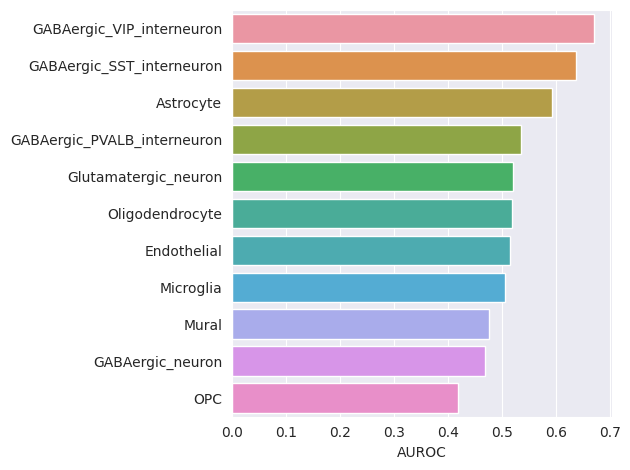

In [20]:
# Barplot
sort_idx = np.argsort(auroc_list)[::-1]
sns.barplot(x=auroc_list[sort_idx], y=cell_types[sort_idx])
plt.xlabel('AUROC')
plt.tight_layout()
plt.savefig('results/auroc.png', dpi=300)

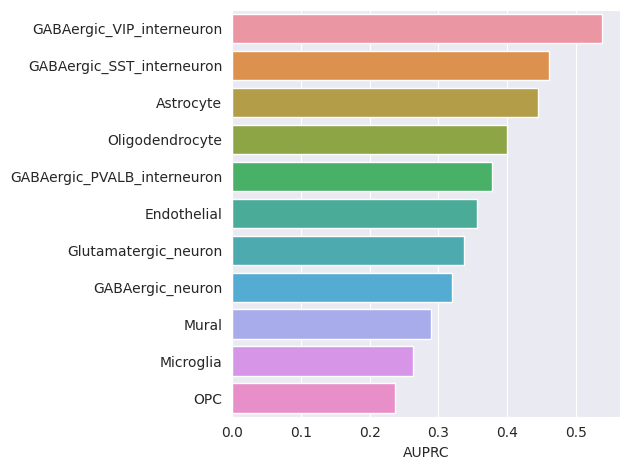

In [28]:
# Barplot
sort_idx = np.argsort(auprc_list)[::-1]
sns.barplot(x=auprc_list[sort_idx], y=cell_types[sort_idx])
plt.xlabel('AUPRC')
plt.tight_layout()
plt.savefig('results/auprc.png', dpi=300)

## Graphs

In [174]:
from hiveplotlib import Axis, Node, HivePlot
from hiveplotlib.converters import networkx_to_nodes_edges
from hiveplotlib.viz import axes_viz_mpl, node_viz_mpl, edge_viz_mpl

# Get best model
best_performing_model = np.argmax(auroc_list)
# auroc_list = [.5] * len(cell_types)
print(f'Best performing model: {cell_types[best_performing_model]} ({auroc_list[best_performing_model]:.3f})')
cell_type = cell_types[best_performing_model]
results_dir = f'results/{cell_type}/'
ad_genes = np.loadtxt(results_dir + 'AD.txt', dtype=str)
notad_genes = np.loadtxt(results_dir + 'notAD.txt', dtype=str)

Best performing model: GABAergic_VIP_interneuron (0.670)


### Base Data

In [213]:
dataset = get_data(cell_type, subset=(100, 100, 100))
data, genes = dataset[0]
train_idx, val_idx = dataset[1]
labels, ad_labels, notad_labels, unknown_labels, known_labels = dataset[2]

# Create graph
graph = pyg.utils.convert.to_networkx(data, node_attrs=['node_name'], edge_attrs=['edge_weight'], to_undirected=True)
graph = nx.relabel_nodes(graph, lambda x: graph.nodes(data=True)[x]['node_name'], copy=False)

AD: 100; notAD: 100; unknown: 100


In [245]:
# Hiveplot
nodes, edges = hpl.converters.networkx_to_nodes_edges(graph)

def plot_hp(subset=genes, ax=None):
    # Import node data
    # Add label
    deg_cen = nx.degree_centrality(graph)
    eig_cen = nx.eigenvector_centrality(graph)
    clo_cen = nx.closeness_centrality(graph)
    for node in nodes:
        deg = deg_cen[node.data['node_name']]
        eig = eig_cen[node.data['node_name']]
        clo = clo_cen[node.data['node_name']]
        node.add_data(data=dict(deg=deg, eig=eig, clo=clo, node_type=node_type))

    # Vizualize (https://geomdata.gitlab.io/hiveplotlib/karate_club.html)
    hp = HivePlot()

    ### nodes ###

    hp.add_nodes(nodes)

    ### axes ###

    axis0 = Axis(axis_id='deg', start=1, end=5, angle=30, long_name='Degree')
    axis1 = Axis(axis_id='eig', start=1, end=5, angle=150, long_name='Eigenvector')
    axis2 = Axis(axis_id='clo', start=1, end=5, angle=270, long_name='Closeness')

    axes = [axis0, axis1, axis2]
    hp.add_axes(axes)

    ### node assignments ###

    # partition the nodes
    all_nodes = subset  # [node.unique_id for node in nodes]

    # assign nodes and sorting procedure to position nodes on axis
    hp.place_nodes_on_axis(axis_id='deg', unique_ids=all_nodes, sorting_feature_to_use='deg')
    hp.place_nodes_on_axis(axis_id='eig', unique_ids=all_nodes, sorting_feature_to_use='eig')
    hp.place_nodes_on_axis(axis_id='clo', unique_ids=all_nodes, sorting_feature_to_use='clo')

    ### edges ###

    hp.connect_axes(edges=edges, axis_id_1='deg', axis_id_2='eig', color='C0')
    hp.connect_axes(edges=edges, axis_id_1='eig', axis_id_2='clo', color='C1')
    hp.connect_axes(edges=edges, axis_id_1='clo', axis_id_2='deg', color='C2')

    # pull out the location of ad and notad
    ad_locations, notad_locations = [], []
    for hp_ax in hp.axes.values():
        locations = hp_ax.node_placements
        ad_locations += list(locations.loc[[g in genes[ad_labels] for g in locations.loc[:, 'unique_id']], ['x', 'y']].values)
        notad_locations += list(locations.loc[[g in genes[notad_labels] for g in locations.loc[:, 'unique_id']], ['x', 'y']].values)
    ad_locations = np.array(ad_locations)
    notad_locations = np.array(notad_locations)

    ### Hive Plot ###

    # plot axes
    if ax is None:
        fig, ax = axes_viz_mpl(hp)
        plt.tight_layout()
    else:
        fig = ax.get_figure()
        axes_viz_mpl(hp, fig=fig, ax=ax)

    # plot nodes
    node_viz_mpl(hp, fig=fig, ax=ax, s=5, color='black')

    # highlight ad and notad
    for x, y in ad_locations:
        ax.scatter(x, y, color='red', s=5, alpha=.5, zorder=2)
    for x, y in notad_locations:
        ax.scatter(x, y, color='teal', s=5, alpha=.5, zorder=2)

    # plot edges
    edge_viz_mpl(hp, fig=fig, ax=ax, alpha=0.7, zorder=-1, linewidth=.003)
    # ax.set_title('Gene Connectivity', fontsize=20, y=0.9)

    ### legend ###

    # # edges
    # custom_lines = [Line2D([0], [0], color=f'C{i}', lw=3, linestyle='-') for i in range(3)]

    # # John A. and Mr. Hi nodes
    # john_a_legend = Line2D([], [], markerfacecolor='red', markeredgecolor='black', marker='o', linestyle='None', markersize=10)
    # custom_lines.append(john_a_legend)

    # mr_hi_legend = Line2D([], [], markerfacecolor='yellow', markeredgecolor='black', marker='o', linestyle='None', markersize=10)
    # custom_lines.append(mr_hi_legend)

    # ax.legend(custom_lines, ['Within Mr. Hi Faction', 'Within John A. Faction', 'Between Factions', 'John A.', 'Mr. Hi'],
    #           loc='upper left', bbox_to_anchor=(0.37, 0.35), title='Social Connections')
    
# plt.savefig('results/prev.png', dpi=300)

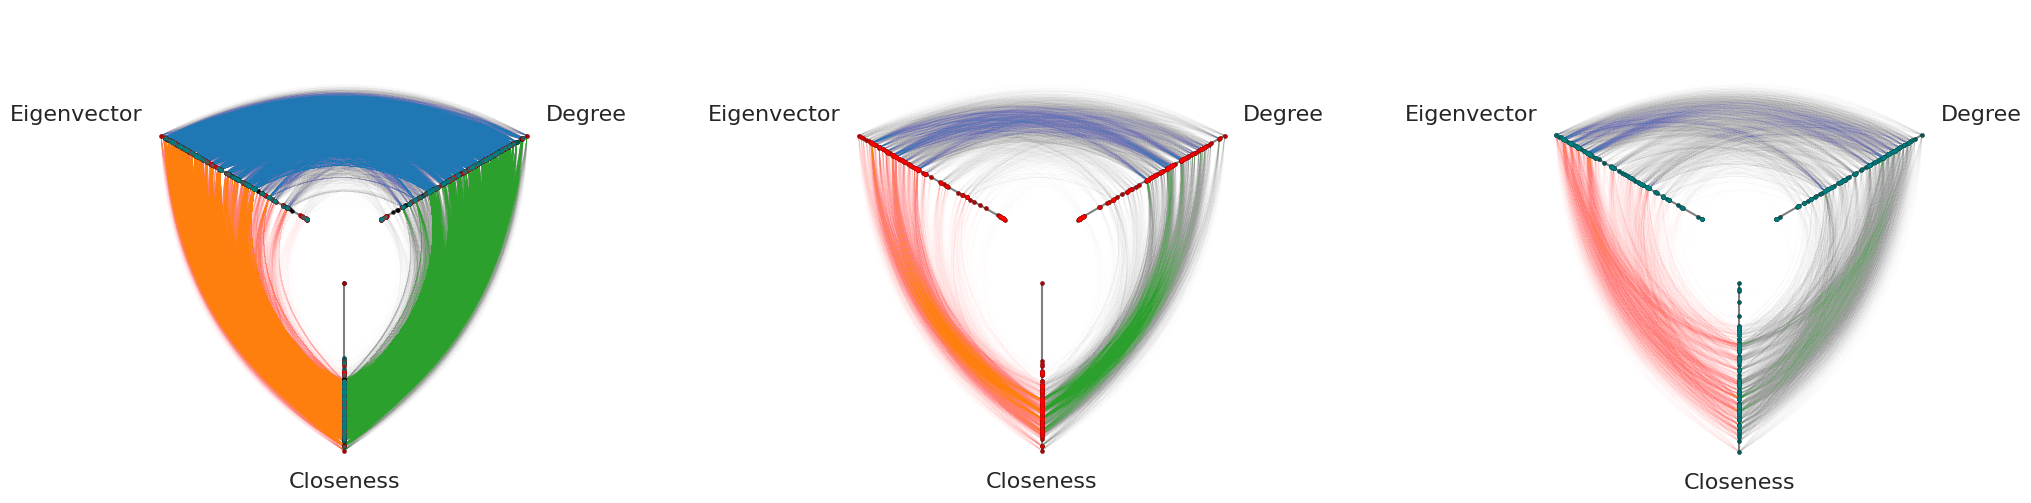

In [252]:
fig, axs = plt.subplots(1, 3, figsize=(24, 6))
plot_hp(subset=genes, ax=axs[0])
plot_hp(subset=genes[ad_labels], ax=axs[1])
plot_hp(subset=genes[notad_labels], ax=axs[2])
plt.subplots_adjust(wspace=.5)

### AD-NotAD Connectivity

In [181]:
gene_list = np.array(list(ad_genes) + list(notad_genes))
dataset = get_data(cell_type, gene_list=gene_list)
data, genes = dataset[0]
train_idx, val_idx = dataset[1]
labels, ad_labels, notad_labels, unknown_labels, known_labels = dataset[2]

# Create graph
graph = pyg.utils.convert.to_networkx(data, node_attrs=['node_name'], edge_attrs=['edge_weight'], to_undirected=True)
graph = nx.relabel_nodes(graph, lambda x: graph.nodes(data=True)[x]['node_name'], copy=False)

AD: 24; notAD: 146; unknown: 154


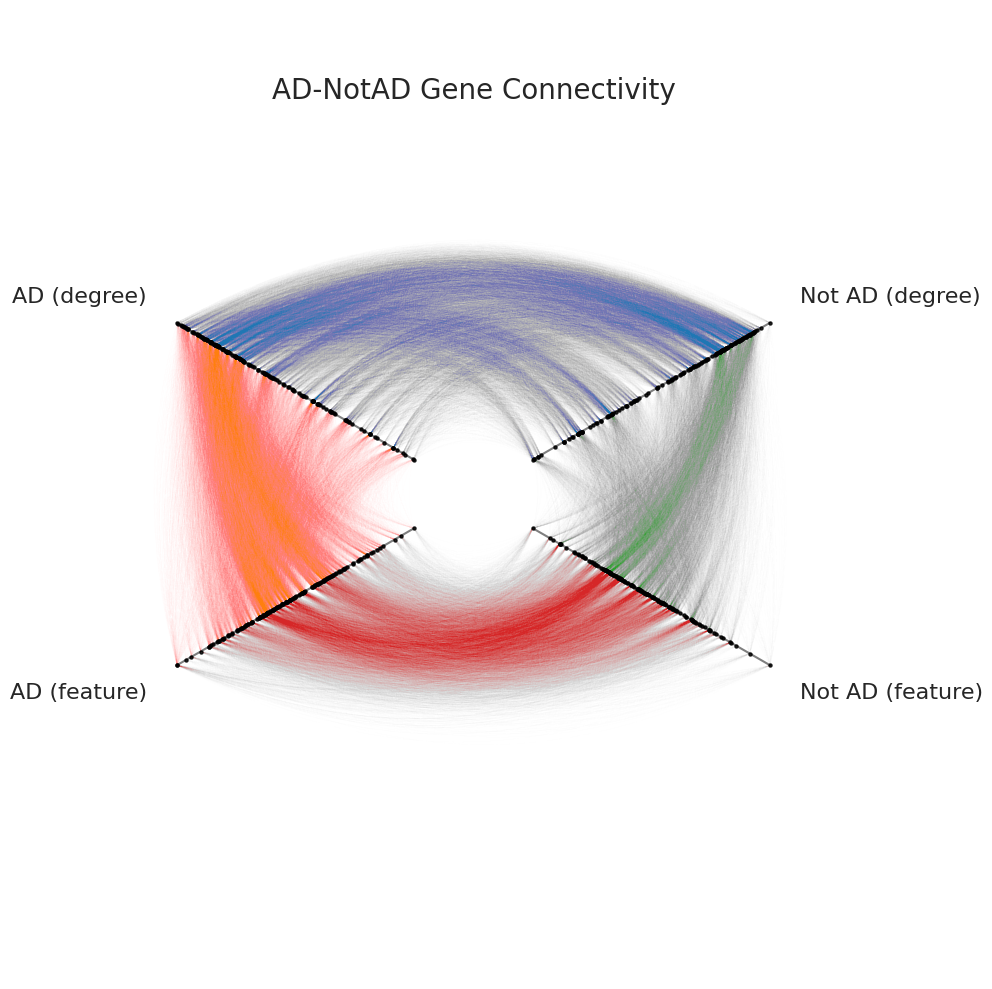

In [182]:
# Hiveplot
nodes, edges = hpl.converters.networkx_to_nodes_edges(graph)

# Generate positions
z = np.load(results_dir + 'embeddings.npy')
z_genes = np.loadtxt(results_dir + 'genes.txt', dtype=str)
z = z[[np.argwhere(g==gene_list)[0][0] for g in z_genes if g in gene_list]]
# PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2).fit_transform(z)[:, 0]
# UMAP
# import umap
# pca = umap.UMAP(n_components=2, random_state=42).fit_transform(z)[:, 0]
# NONE
# pca = z[:, 0]

# Import node data
# Add label
for node in nodes:
    if node.data['node_name'] in ad_genes:
        node_type = 'ad'
    elif node.data['node_name'] in notad_genes:
        node_type = 'notad'
    else:
        node_type = 'unknown'
    degree = int((data.edge_index[0] == np.argwhere(gene_list == node.data['node_name'])[0][0]).sum())
    val = pca[np.argwhere(node.data['node_name']==gene_list)[0][0]]
    node.add_data(data=dict(val=val, degree=degree, node_type=node_type))

# Vizualize (https://geomdata.gitlab.io/hiveplotlib/karate_club.html)
hp = HivePlot()

### nodes ###

hp.add_nodes(nodes)

### axes ###

axis0 = Axis(axis_id='ad_val', start=1, end=5, angle=180 + 30, long_name='AD (feature)')
axis1 = Axis(axis_id='ad_deg', start=1, end=5, angle=180 - 30, long_name='AD (degree)')
axis2 = Axis(axis_id='notad_val', start=1, end=5, angle=-30, long_name='Not AD (feature)')
axis3 = Axis(axis_id='notad_deg', start=1, end=5, angle=30, long_name='Not AD (degree)')

axes = [axis0, axis1, axis2, axis3]
hp.add_axes(axes)

### node assignments ###

# partition the nodes
ad_nodes = [node.unique_id for node in nodes if node.data['node_type'] == 'ad']
notad_nodes = [node.unique_id for node in nodes if node.data['node_type'] == 'notad']

# assign nodes and sorting procedure to position nodes on axis
hp.place_nodes_on_axis(axis_id='ad_val', unique_ids=ad_nodes, sorting_feature_to_use='val')
hp.place_nodes_on_axis(axis_id='ad_deg', unique_ids=ad_nodes, sorting_feature_to_use='degree')
hp.place_nodes_on_axis(axis_id='notad_val', unique_ids=notad_nodes, sorting_feature_to_use='val')
hp.place_nodes_on_axis(axis_id='notad_deg', unique_ids=notad_nodes, sorting_feature_to_use='degree')

### edges ###

hp.connect_axes(edges=edges, axis_id_1='ad_deg', axis_id_2='ad_val', color='C1')
hp.connect_axes(edges=edges, axis_id_1='notad_deg', axis_id_2='notad_val', color='C2')
hp.connect_axes(edges=edges, axis_id_1='ad_deg', axis_id_2='notad_deg', color='C0')
hp.connect_axes(edges=edges, axis_id_1='ad_val', axis_id_2='notad_val', color='C3')

# pull out the location of the John A. and Mr. Hi nodes for visual emphasis later
# john_a_degree_locations = karate_hp.axes['john_degree'].node_placements
# john_a_node = john_a_degree_locations.loc[john_a_degree_locations.loc[:, 'unique_id'] == 33, ['x', 'y']].values.flatten()

# mr_hi_degree_locations = karate_hp.axes['hi_degree'].node_placements
# mr_hi_node = mr_hi_degree_locations.loc[mr_hi_degree_locations.loc[:, 'unique_id'] == 0, ['x', 'y']].values.flatten()

### Hive Plot ###

# plot axes
fig, ax = axes_viz_mpl(hp)

# plot nodes
node_viz_mpl(hp, fig=fig, ax=ax, s=5, color='black')

# highlight Mr. Hi and John. A on the degree axes
# ax.scatter(john_a_node[0], john_a_node[1], facecolor='red', edgecolor='black', s=150, lw=2, zorder=2)
# ax.scatter(mr_hi_node[0], mr_hi_node[1], facecolor='yellow', edgecolor='black', s=150, lw=2, zorder=2)

# plot edges
edge_viz_mpl(hp, fig=fig, ax=ax, alpha=0.7, zorder=-1, linewidth=.002)
ax.set_title('AD-NotAD Gene Connectivity', fontsize=20, y=0.9);

### legend ###

# # edges
# custom_lines = [Line2D([0], [0], color=f'C{i}', lw=3, linestyle='-') for i in range(3)]

# # John A. and Mr. Hi nodes
# john_a_legend = Line2D([], [], markerfacecolor='red', markeredgecolor='black', marker='o', linestyle='None', markersize=10)
# custom_lines.append(john_a_legend)

# mr_hi_legend = Line2D([], [], markerfacecolor='yellow', markeredgecolor='black', marker='o', linestyle='None', markersize=10)
# custom_lines.append(mr_hi_legend)

# ax.legend(custom_lines, ['Within Mr. Hi Faction', 'Within John A. Faction', 'Between Factions', 'John A.', 'Mr. Hi'],
#           loc='upper left', bbox_to_anchor=(0.37, 0.35), title='Social Connections')

plt.tight_layout()
plt.savefig('results/eval.png', dpi=300)

### AD Connectivity

In [183]:
gene_list = np.array(list(ad_genes))
dataset = get_data(cell_type, gene_list=gene_list)
data, genes = dataset[0]
train_idx, val_idx = dataset[1]
labels, ad_labels, notad_labels, unknown_labels, known_labels = dataset[2]

# Create graph
graph = pyg.utils.convert.to_networkx(data, node_attrs=['node_name'], edge_attrs=['edge_weight'], to_undirected=True)
graph = nx.relabel_nodes(graph, lambda x: graph.nodes(data=True)[x]['node_name'], copy=False)

AD: 20; notAD: 72; unknown: 78


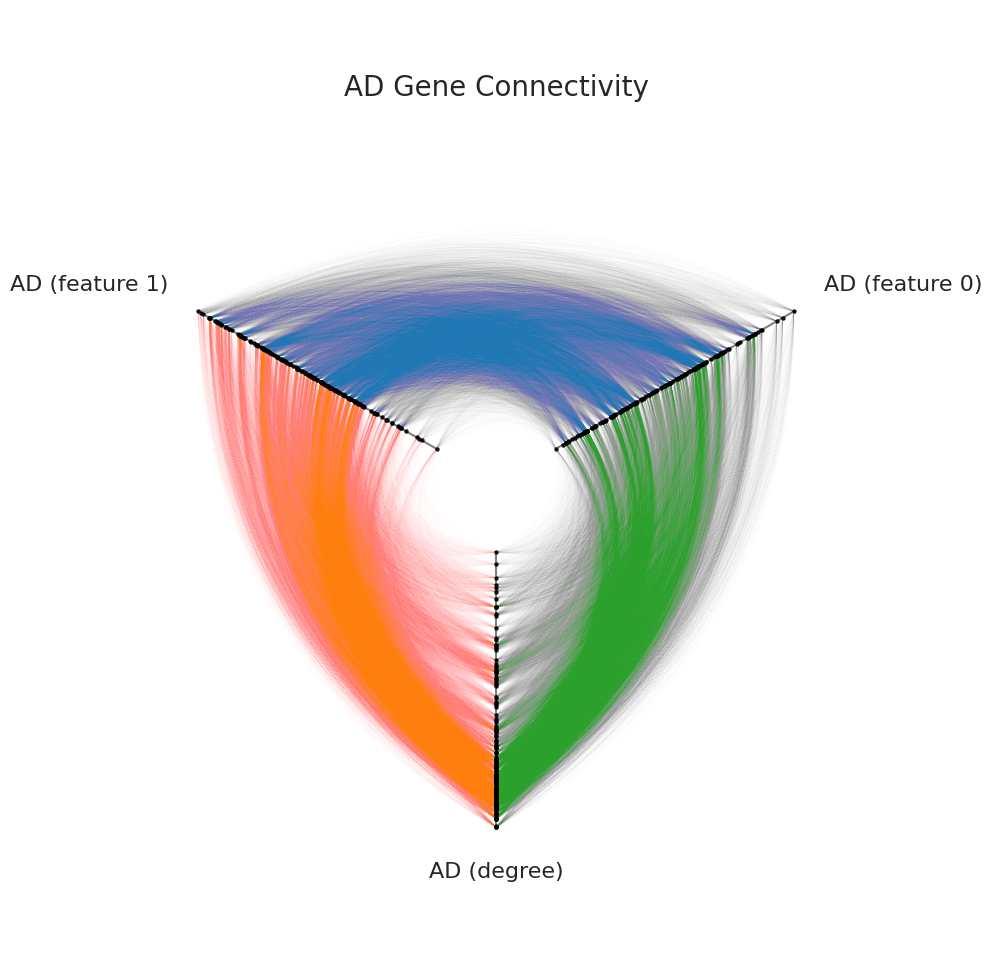

In [184]:
# Hiveplot
nodes, edges = hpl.converters.networkx_to_nodes_edges(graph)

# Generate positions
z = np.load(results_dir + 'embeddings.npy')
z_genes = np.loadtxt(results_dir + 'genes.txt', dtype=str)
z = z[[np.argwhere(g==gene_list)[0][0] for g in z_genes if g in gene_list]]
# PCA
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2).fit_transform(z)[:, :2]
# UMAP
# import umap
# pca = umap.UMAP(n_components=2, random_state=42).fit_transform(z)[:, 0]
# NONE
pca = z[:, :2]

# Import node data
# Add label
for node in nodes:
    degree = int((data.edge_index[0] == np.argwhere(gene_list == node.data['node_name'])[0][0]).sum())
    val0, val1 = pca[np.argwhere(node.data['node_name']==gene_list)[0][0], :]
    node.add_data(data=dict(val0=val0, val1=val1, degree=degree, node_type=node_type))

# Vizualize (https://geomdata.gitlab.io/hiveplotlib/karate_club.html)
hp = HivePlot()

### nodes ###

hp.add_nodes(nodes)

### axes ###

axis0 = Axis(axis_id='ad_val0', start=1, end=5, angle=30, long_name='AD (feature 0)')
axis1 = Axis(axis_id='ad_val1', start=1, end=5, angle=150, long_name='AD (feature 1)')
axis2 = Axis(axis_id='ad_deg', start=1, end=5, angle=270, long_name='AD (degree)')

axes = [axis0, axis1, axis2]
hp.add_axes(axes)

### node assignments ###

# partition the nodes
all_nodes = [node.unique_id for node in nodes]

# assign nodes and sorting procedure to position nodes on axis
hp.place_nodes_on_axis(axis_id='ad_val0', unique_ids=all_nodes, sorting_feature_to_use='val0')
hp.place_nodes_on_axis(axis_id='ad_val1', unique_ids=all_nodes, sorting_feature_to_use='val1')
hp.place_nodes_on_axis(axis_id='ad_deg', unique_ids=all_nodes, sorting_feature_to_use='degree')

### edges ###

hp.connect_axes(edges=edges, axis_id_1='ad_val0', axis_id_2='ad_val1', color='C0')
hp.connect_axes(edges=edges, axis_id_1='ad_val1', axis_id_2='ad_deg', color='C1')
hp.connect_axes(edges=edges, axis_id_1='ad_deg', axis_id_2='ad_val0', color='C2')

### Hive Plot ###

# plot axes
fig, ax = axes_viz_mpl(hp)

# plot nodes
node_viz_mpl(hp, fig=fig, ax=ax, s=5, color='black')

# highlight Mr. Hi and John. A on the degree axes
# ax.scatter(john_a_node[0], john_a_node[1], facecolor='red', edgecolor='black', s=150, lw=2, zorder=2)
# ax.scatter(mr_hi_node[0], mr_hi_node[1], facecolor='yellow', edgecolor='black', s=150, lw=2, zorder=2)

# plot edges
edge_viz_mpl(hp, fig=fig, ax=ax, alpha=0.7, zorder=-1, linewidth=.003)
ax.set_title('AD Gene Connectivity', fontsize=20, y=0.9);

### legend ###

# # edges
# custom_lines = [Line2D([0], [0], color=f'C{i}', lw=3, linestyle='-') for i in range(3)]

# # John A. and Mr. Hi nodes
# john_a_legend = Line2D([], [], markerfacecolor='red', markeredgecolor='black', marker='o', linestyle='None', markersize=10)
# custom_lines.append(john_a_legend)

# mr_hi_legend = Line2D([], [], markerfacecolor='yellow', markeredgecolor='black', marker='o', linestyle='None', markersize=10)
# custom_lines.append(mr_hi_legend)

# ax.legend(custom_lines, ['Within Mr. Hi Faction', 'Within John A. Faction', 'Between Factions', 'John A.', 'Mr. Hi'],
#           loc='upper left', bbox_to_anchor=(0.37, 0.35), title='Social Connections')

plt.tight_layout()
plt.savefig('results/evalAD.png', dpi=300)

### NotAD Connectivity

In [185]:
gene_list = np.array(list(notad_genes))
dataset = get_data(cell_type, gene_list=gene_list)
data, genes = dataset[0]
train_idx, val_idx = dataset[1]
labels, ad_labels, notad_labels, unknown_labels, known_labels = dataset[2]

# Create graph
graph = pyg.utils.convert.to_networkx(data, node_attrs=['node_name'], edge_attrs=['edge_weight'], to_undirected=True)
graph = nx.relabel_nodes(graph, lambda x: graph.nodes(data=True)[x]['node_name'], copy=False)

AD: 4; notAD: 74; unknown: 76


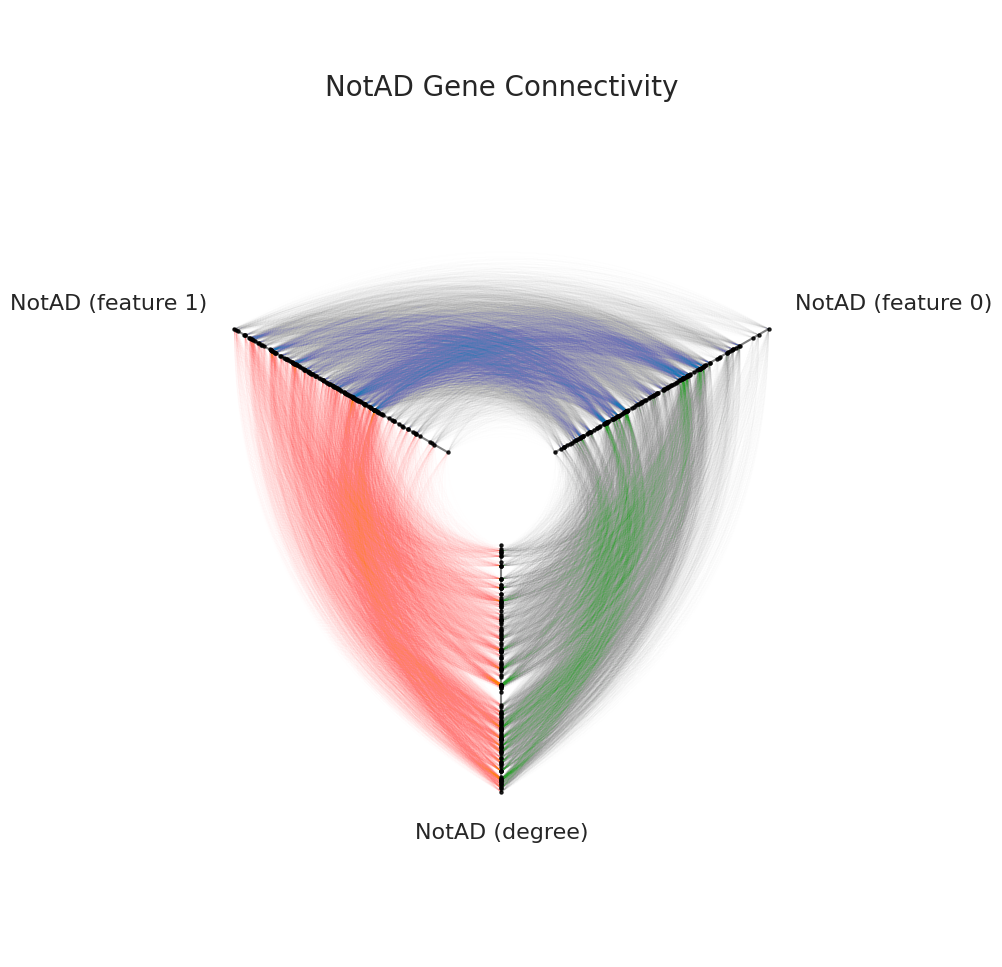

In [186]:
# Hiveplot
nodes, edges = hpl.converters.networkx_to_nodes_edges(graph)

# Generate positions
z = np.load(results_dir + 'embeddings.npy')
z_genes = np.loadtxt(results_dir + 'genes.txt', dtype=str)
z = z[[np.argwhere(g==gene_list)[0][0] for g in z_genes if g in gene_list]]
# PCA
# from sklearn.decomposition import PCA
# pca = PCA(n_components=2).fit_transform(z)[:, :2]
# UMAP
# import umap
# pca = umap.UMAP(n_components=2, random_state=42).fit_transform(z)[:, 0]
# NONE
pca = z[:, :2]

# Import node data
# Add label
for node in nodes:
    degree = int((data.edge_index[0] == np.argwhere(gene_list == node.data['node_name'])[0][0]).sum())
    val0, val1 = pca[np.argwhere(node.data['node_name']==gene_list)[0][0], :]
    node.add_data(data=dict(val0=val0, val1=val1, degree=degree, node_type=node_type))

# Vizualize (https://geomdata.gitlab.io/hiveplotlib/karate_club.html)
hp = HivePlot()

### nodes ###

hp.add_nodes(nodes)

### axes ###

axis0 = Axis(axis_id='ad_val0', start=1, end=5, angle=30, long_name='NotAD (feature 0)')
axis1 = Axis(axis_id='ad_val1', start=1, end=5, angle=150, long_name='NotAD (feature 1)')
axis2 = Axis(axis_id='ad_deg', start=1, end=5, angle=270, long_name='NotAD (degree)')

axes = [axis0, axis1, axis2]
hp.add_axes(axes)

### node assignments ###

# partition the nodes
all_nodes = [node.unique_id for node in nodes]

# assign nodes and sorting procedure to position nodes on axis
hp.place_nodes_on_axis(axis_id='ad_val0', unique_ids=all_nodes, sorting_feature_to_use='val0')
hp.place_nodes_on_axis(axis_id='ad_val1', unique_ids=all_nodes, sorting_feature_to_use='val1')
hp.place_nodes_on_axis(axis_id='ad_deg', unique_ids=all_nodes, sorting_feature_to_use='degree')

### edges ###

hp.connect_axes(edges=edges, axis_id_1='ad_val0', axis_id_2='ad_val1', color='C0')
hp.connect_axes(edges=edges, axis_id_1='ad_val1', axis_id_2='ad_deg', color='C1')
hp.connect_axes(edges=edges, axis_id_1='ad_deg', axis_id_2='ad_val0', color='C2')

### Hive Plot ###

# plot axes
fig, ax = axes_viz_mpl(hp)

# plot nodes
node_viz_mpl(hp, fig=fig, ax=ax, s=5, color='black')

# highlight Mr. Hi and John. A on the degree axes
# ax.scatter(john_a_node[0], john_a_node[1], facecolor='red', edgecolor='black', s=150, lw=2, zorder=2)
# ax.scatter(mr_hi_node[0], mr_hi_node[1], facecolor='yellow', edgecolor='black', s=150, lw=2, zorder=2)

# plot edges
edge_viz_mpl(hp, fig=fig, ax=ax, alpha=0.7, zorder=-1, linewidth=.003)
ax.set_title('NotAD Gene Connectivity', fontsize=20, y=0.9);

### legend ###

# # edges
# custom_lines = [Line2D([0], [0], color=f'C{i}', lw=3, linestyle='-') for i in range(3)]

# # John A. and Mr. Hi nodes
# john_a_legend = Line2D([], [], markerfacecolor='red', markeredgecolor='black', marker='o', linestyle='None', markersize=10)
# custom_lines.append(john_a_legend)

# mr_hi_legend = Line2D([], [], markerfacecolor='yellow', markeredgecolor='black', marker='o', linestyle='None', markersize=10)
# custom_lines.append(mr_hi_legend)

# ax.legend(custom_lines, ['Within Mr. Hi Faction', 'Within John A. Faction', 'Between Factions', 'John A.', 'Mr. Hi'],
#           loc='upper left', bbox_to_anchor=(0.37, 0.35), title='Social Connections')

plt.tight_layout()
plt.savefig('results/evalnotAD.png', dpi=300)

## Common AD

In [187]:
gene_counts = {}
for cell_type in cell_types:
    results_dir = f'results/{cell_type}/'
    for g in np.loadtxt(results_dir + 'AD.txt', dtype=str):
        if g not in gene_counts:
            gene_counts[g] = 0
        gene_counts[g] += 1
filtered_genes = [g for g, v in gene_counts.items() if v > 1]
np.savetxt('results/commonAD.txt', filtered_genes, fmt='%s')